In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.optimize import curve_fit

## Define Functions

In [2]:
## calculate cost of perturbation due to carbon
## input: temperature profile, perturbed temperature profile, total consumption, and discount function

def cost_of_perturbation(T, T_perturb, W, discount_function, gamma=2, D0=0.00267):
    S_Wt = D0*T**gamma
    S_Wt_perturb = D0*T_perturb**gamma
    consumption_loss_fraction = S_Wt_perturb-S_Wt
    absolute_consumption_loss = consumption_loss_fraction*W
    discounted_consumption_loss = absolute_consumption_loss*discount_function
#     area = simps(discounted_consumption_loss, dx=1)
    area = sum(discounted_consumption_loss)
    cost = area*10**12  # convert to dollar amount
    
    return cost

In [3]:
## calculate abatement given a carbon price

# default settings
P_50 = 100  # 187.5 * 0.7625000000000001
P_100 = 300  # 187.5
consumption_growth = 0.03
W_2019 = 80
# consumption_discount=0.035
consumption_discount = consumption_growth + 0.015
s = 0.05
r = 0.04

def abatement(P, P0, P_50=P_50, r=r, s=s, P_100=P_100):  # 0.05
    if P0 >= P_50:
        print("P0 is greater than P_50")
    elif ((P_100-P0)/(P_50-P0))**(s/r) <= 2:
        print("MAC curve condition not satisfied")
    
    P_h = P0 + ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)
    Am = 1 + ((P_100 - P0) / (P_h - P0)) ** (-s / r)
    
    A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
    
    return A

In [4]:
## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

# Steps outlined in Email

## 1. Create Unperturbed Temperature Profile

In [5]:
# get historical data (taken from chrisroadmap)

T_gas_df = pd.read_csv("T_gas.csv", index_col=0)

T_2019 = T_gas_df['CO2_best'][2019]

T_2019 = 1.2

In [6]:
T_gas_df

,CO2_p05,CO2_best,CO2_p95,CH4_p05,CH4_best,CH4_p95,N2O_p05,N2O_best,N2O_p95,otherGHG_p05,...,anthro_p95,volcanic_p05,volcanic_best,volcanic_p95,solar_p05,solar_best,solar_p95,total_p05,total_best,total_p95
year,,,,,,,,,,,,,,,,,,,,,
1750.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1751.0,0.000063,0.000078,0.000104,0.000021,0.000028,0.000038,0.000003,0.000004,0.000005,3.336574e-11,...,0.000991,0.001458,0.003652,0.006261,0.002195,0.004637,0.007482,0.004874,0.008851,0.013245
1752.0,0.000234,0.000288,0.000370,0.000078,0.000104,0.000136,0.000012,0.000015,0.000019,1.236761e-10,...,0.003293,0.002497,0.006507,0.011455,0.002128,0.005561,0.009812,0.006393,0.013875,0.022041
1753.0,0.000490,0.000599,0.000749,0.000163,0.000215,0.000276,0.000025,0.000031,0.000039,2.589871e-10,...,0.005303,0.003234,0.008737,0.015902,-0.001555,0.002997,0.007192,0.003865,0.014541,0.025931
1754.0,0.000809,0.000987,0.001216,0.000270,0.000354,0.000452,0.000042,0.000051,0.000064,4.287973e-10,...,0.005352,0.003785,0.010506,0.019564,-0.009705,-0.002156,0.001567,-0.002897,0.011326,0.025058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015.0,0.690630,0.946447,1.315948,0.187758,0.269860,0.385269,0.067561,0.092850,0.126852,1.330359e-01,...,1.497255,-0.032496,-0.020661,-0.013130,-0.029680,0.006904,0.049407,0.868757,1.156062,1.486544
2016.0,0.702726,0.962928,1.338630,0.188901,0.271437,0.387212,0.068619,0.094311,0.128864,1.338915e-01,...,1.533906,-0.033707,-0.021568,-0.013486,-0.031488,0.004876,0.047502,0.890845,1.185044,1.525629
2017.0,0.715303,0.980030,1.362135,0.190066,0.273081,0.389542,0.069654,0.095766,0.130865,1.348695e-01,...,1.573725,-0.031721,-0.020004,-0.011939,-0.035521,0.001077,0.044231,0.915329,1.214310,1.561045


In [7]:
start_year = 1750
last_historical_year = 2019
end_year = 3000

years = np.arange(start_year, end_year+1)
T_forecast_years = np.arange(last_historical_year, end_year+1)
T_forecast_length = end_year - last_historical_year + 1

In [8]:
historical_years = np.arange(start_year, last_historical_year+1)
CO2_column = 1.2 * np.ones(len(historical_years))
T_gas = {'year': historical_years, 'CO2_best': CO2_column}

In [9]:
# T_gas_df = pd.DataFrame(T_gas)

In [10]:
# T_gas_df['CO2_best'] = 1.2 * np.ones(len(T_gas_df))

In [11]:
delta_T = 3
alpha = 0.02
T_forecast = T_2019 + (delta_T-T_2019) * (1 - np.exp(-alpha*np.arange(T_forecast_length)))

In [12]:
T = np.concatenate([T_gas_df['CO2_best'],T_forecast[1:]])

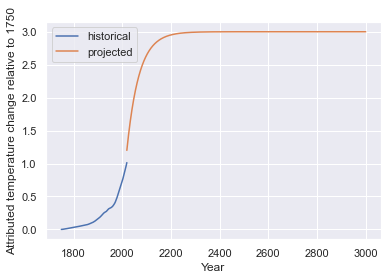

In [13]:
plt.plot(T_gas_df['CO2_best'], label="historical")
# plt.plot(T_gas_df["year"], T_gas_df['CO2_best'], label="historical")
plt.plot(T_forecast_years, T_forecast, label="projected")
plt.xlabel("Year")
plt.ylabel("Attributed temperature change relative to 1750")
plt.legend()

## Total Consumption

In [14]:
W = []

# for i in range(len(years)):
#     W.append(W0*consumption_growth**(i-(last_historical_year - start_year)))
    
for i in range(len(years)):
    W.append(W_2019*np.exp(consumption_growth*(i-(last_historical_year - start_year))))

W = np.asarray(W)

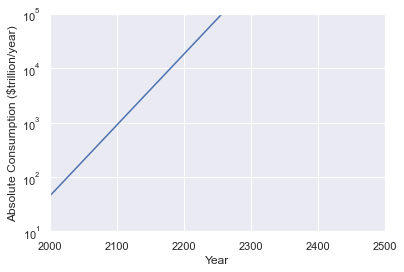

In [15]:
plt.plot(years, W)
plt.xlabel("Year")
plt.ylabel("Absolute Consumption ($trillion/year)")
# plt.xlim(2000, 2100)
# plt.ylim(0, 400)
plt.xlim(2000, 2500)
plt.ylim(10, 100000)
plt.yscale("log")

alternative functional form for above for the fast transition

## 2. Calculate SCC as a function of time for a range of years

In [47]:
## years to calculate SCC
first_perturbed_year = last_historical_year
last_perturbed_year = 2500
year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

# consumption_discount = 0.035
# consumption_discount = consumption_growth + 0.015

SCC_list = []

for j in range(len(year_of_perturbation)):
    ## define perturbed temperature profile for a given year
    T_TCRE = 0.00054  # need to check this for FAIR!
    k_s = 0.12

    T_p = np.zeros(T_forecast_length)
    for i in range(len(T_forecast_years)):
        if year_of_perturbation[j] <= T_forecast_years[i]:
            T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))
    T_forecast_perturbed = T_forecast+T_p
    T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])

    ## define discount function
    num_of_years = len(years)
    discount_function = np.zeros(num_of_years)
    

    for i in range(num_of_years):
        if years[i] >= year_of_perturbation[j]:
            discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
    
    if j  == 0:
        print(SCC)
        print(discount_function[first_perturbed_year-start_year+2])
    
    ## calculate SCC
    cost = cost_of_perturbation(T=T, T_perturb=T_perturbed, W=W, discount_function=discount_function)
    SCC = cost/(10**9)
    
    if SCC < P_100:
        SCC_list.append(SCC)
    else:
        SCC_list.append(P_100)
        break

306.6747975842411
0.9139311852712282


In [17]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

In [18]:
SCC_array

array([ 31.82689038,  32.98349256,  34.17720121,  35.40916529,
        36.68056898,  37.99263268,  39.34661418,  40.74380976,
        42.18555538,  43.67322787,  45.2082462 ,  46.79207278,
        48.42621473,  50.1122253 ,  51.85170524,  53.64630427,
        55.49772257,  57.40771229,  59.37807919,  61.41068423,
        63.50744527,  65.67033881,  67.90140175,  70.20273327,
        72.57649672,  75.02492154,  77.55030533,  80.15501589,
        82.84149337,  85.61225248,  88.46988477,  91.41706095,
        94.45653332,  97.59113827, 100.82379879, 104.15752719,
       107.59542776, 111.14069958, 114.79663946, 118.56664485,
       122.45421695, 126.46296388, 130.59660388, 134.85896876,
       139.25400726, 143.78578871, 148.45850661, 153.27648252,
       158.24416984, 163.36615796, 168.64717629, 174.0920986 ,
       179.70594738, 185.49389841, 191.4612854 , 197.61360479,
       203.95652076, 210.49587031, 217.2376685 , 224.18811395,
       231.35359435, 238.74069228, 246.35619112, 254.20

Text(0, 0.5, 'SCC ($)')

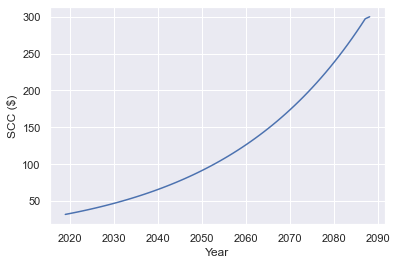

In [19]:
plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

### Check 100% abatement has been achieved!

In [20]:
if SCC_array[-1] < P_100:
    print("P_100 not achieved by achieved by final perturbed year")

In [21]:
SCC_forecasted = []

for i in range(T_forecast_length):
    if i < len(SCC_array):
        SCC_forecasted.append(SCC_array[i])
    else:
#         SCC_forecasted.append(SCC_array[-1])
        SCC_forecasted.append(P_100)

SCC_forecasted = np.array(SCC_forecasted)

In [22]:
# SCC_forecasted

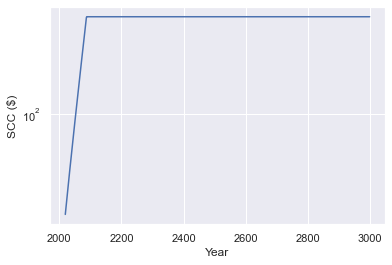

In [23]:
plt.plot(T_forecast_years, SCC_forecasted)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

## 3. Abatement as a function of time

In [24]:
P0 = SCC_forecasted[0]

In [25]:
forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)  # , r=consumption_discount

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_45727/1668003146.py:22: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


problems with certain values due to constraints of the model

Text(0, 0.5, 'Abatement')

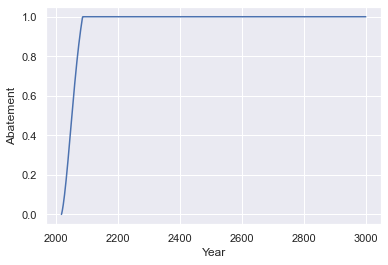

In [26]:
plt.plot(T_forecast_years, forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

## 4. Abatement to emissions

In [27]:
ssp_df = pd.read_csv("ssp245.csv", index_col=0)

In [28]:
ssp245_CO2_past = ssp_df["carbon_dioxide"]*(44/12)  

In [29]:
CO2_baseline = ssp245_CO2_past[2019] # set baseline to current emissions

In [30]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

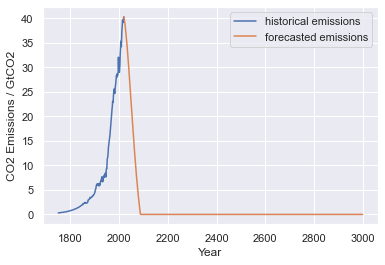

In [31]:
plt.plot(ssp245_CO2_past, label="historical emissions")
plt.plot(T_forecast_years, forecasted_emissions, label="forecasted emissions")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions / GtCO2")
plt.legend()

In [32]:
# for i in range(len(forecasted_emissions)-1):
#     step = forecasted_emissions[i] - forecasted_emissions[i+1]
#     if step > 0.4:
#         print(i)

## 5. Cumulative Emissions to Temperature Change

In [33]:
cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

In [34]:
temperature_change = T_TCRE*cumulative_emissions_array

In [35]:
max(temperature_change)

0.7552517983686974

In [36]:
T_forecast_iteration0 = T_2019 + temperature_change
# T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

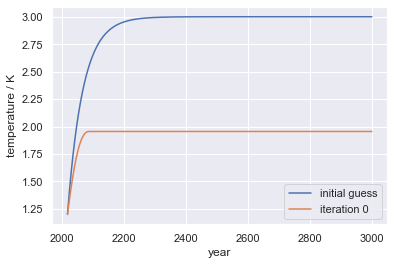

In [37]:
plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_iteration0, label="iteration 0")
# plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("year")
plt.ylabel("temperature / K")
plt.legend()

# Iterating Further

In [38]:
# T_forecast_first_loop = T_forecast_iteration0_plateau
# T_forecast_iteration = T_forecast_iteration0_plateau

In [39]:
T_forecast_first_loop = T_forecast_iteration0
T_forecast_iteration = T_forecast_iteration0

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_45727/1668003146.py:22: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_45727/1668003146.py:22: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_45727/1668003146.py:22: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


3


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_45727/1668003146.py:22: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


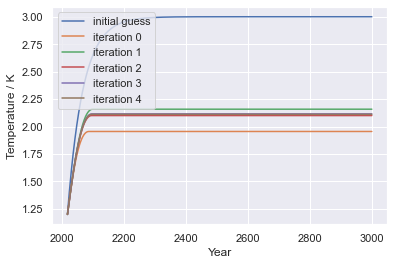

In [40]:
num_of_iterations = 99

first_perturbed_year = last_historical_year

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(T_forecast_years, T_forecast, label="initial guess")
plt.plot(T_forecast_years, T_forecast_first_loop, label="iteration 0")

for k in range(num_of_iterations):
    T_iteration = np.concatenate([T_gas_df['CO2_best'],T_forecast_iteration[1:]])

    SCC_list = []

    for j in range(len(year_of_perturbation)):
        ## define perturbation
        T_TCRE = 0.00054  # need to check this! *100 for 100GtCO2 added
        k_s = 0.12

        T_p = np.zeros(T_forecast_length)

        for i in range(len(T_forecast_years)):
            if year_of_perturbation[j] <= T_forecast_years[i]:
                T_p[i] = T_TCRE*(1-np.exp(-k_s*(T_forecast_years[i]-year_of_perturbation[j])))

        T_forecast_perturbed = T_forecast_iteration+T_p

        T_perturbed = np.concatenate([T_gas_df['CO2_best'],T_forecast_perturbed[1:]])

        ## define discount function
        num_of_years = len(years)

        discount_function = np.zeros(num_of_years)

        for i in range(num_of_years):
            if years[i] >= year_of_perturbation[j]:
                discount_function[i] = np.exp(-consumption_discount*(years[i]-year_of_perturbation[j]))
        cost = cost_of_perturbation(T=T_iteration, T_perturb=T_perturbed, W=W, discount_function=discount_function)
        SCC = cost/(10**9)
        if SCC < P_100:
            SCC_list.append(SCC)
        else:
            SCC_list.append(P_100)
            break

    SCC_array = np.asarray(SCC_list)

    SCC_forecasted = []

    for i in range(T_forecast_length):
        if i < len(SCC_array):
            SCC_forecasted.append(SCC_array[i])
        else:
            SCC_forecasted.append(P_100)

    SCC_forecasted = np.array(SCC_forecasted)

    P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)  # , r=consumption_discount
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

    cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

    temperature_change = T_TCRE*cumulative_emissions_array
    
    T_forecast_iteration = T_2019 + temperature_change
    
    plt.plot(T_forecast_years, T_forecast_iteration, label="iteration "+str(k+1))
    
    if k == 0:
        peak_T = max(T_forecast_iteration)
    else:
        previous_peak_T = peak_T
        peak_T = max(T_forecast_iteration)
        if abs(peak_T - previous_peak_T) < 0.005:
            print(k)
            break
    
    if k == num_of_iterations - 1:
        print("convergence condition not achieved")
        print(f"{consumption_discount=}")
        print(f"{consumption_growth=}")
        print(f"{P_50=}")
        print(f"{s=}")
        print(f"{r=}")
        print(f"{P_100=}")

plt.xlabel("Year")
plt.ylabel("Temperature / K")
plt.legend()

***this is fairly analogous to the Newton-Raphson Method***
- the initial temperature profile is essentially just a starting guess; getting pushed toward temperature profile solution
- could stop the iterations when the difference between two consecutive lines is small

In [41]:
## peak Temperature
max(T_forecast_iteration)

2.1114489953478954

under default settings: 2.435168016568933

- max ~2GtCO2 in year (look in IAMs)
- directions MACC non...
- comment on efficiency
- equation on flowchart
- balance between forcing log and errors
- gradient MACC
- table for Sobol
- peak warming and year of peak warming; scatter with growth rate